In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image
import io, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import optuna
from sklearn.model_selection import TimeSeriesSplit
from transformers import BertModel, BertTokenizer
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [70]:
train_df = pd.read_csv('/kaggle/input/behaviour-simulation-train/behaviour_simulation_train.csv')
train_df.head()

,id,date,likes,content,username,media,inferred company,likes_class
0,1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons,0-1000
1,2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent,1000-5000
2,3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc,0-1000
3,4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams,0-1000
4,5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent,0-1000


In [53]:
import re
import emoji
import contractions
from nltk.corpus import stopwords
from joblib import Parallel, delayed
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def process_hashtags(text):
    return re.sub(r'#(\w+)', lambda m: ' '.join(['#' + w.lower() for w in re.findall(r'[A-Za-z][^A-Z]*', m.group(1))]), text)

def expand_contractions(text):
    return contractions.fix(text)

def reduce_repeated_chars(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def replace_emojis_with_text(text):
    return emoji.demojize(text)

def normalize_numbers(text):
    return re.sub(r'\d+', '<NUM>', text)

def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

def clean_text_pipeline(text):
    if not isinstance(text, str):
        text = ''

    text = re.sub(r'<mention>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = process_hashtags(text)
    text = expand_contractions(text)
    text = replace_emojis_with_text(text)
    text = reduce_repeated_chars(text)
    text = normalize_numbers(text)
    text = remove_stop_words(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
train_df['cleaned_content'] = Parallel(n_jobs=-1)(delayed(clean_text_pipeline)(text) for text in train_df['content'])s
train_df[['content', 'cleaned_content']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# base_images_path = '/kaggle/input/adobe-human-behavior-0-50k/train_images'
# for img_path in os.listdir(base_images_path):
#     img = np.array(Image.open(os.path.join(base_images_path, img_path)))
#     plt.imshow(img)
#     print(img_path.split('.'))
#     break

In [6]:
bins = [0, 1000, 5000, float('inf')]
labels = ['0-1000', '1000-5000', '>=5000']

train_df['likes_class'] = pd.cut(train_df['likes'], bins=bins, labels=labels, right=False)

mean_likes_by_class = train_df.groupby('likes_class')['likes'].mean().to_dict()

print(mean_likes_by_class)

{'0-1000': 150.29876586446588, '1000-5000': 2114.3986468108255, '>=5000': 16511.041423866227}


In [51]:
train_df['likes_class'].value_counts()

likes_class
0-1000       262694
1000-5000     29412
>=5000         7894
Name: count, dtype: int64

In [8]:
train_df.loc[train_df['likes_class']=='>=5000']['likes'].std()

25525.58016847943

In [9]:
companies = np.unique(train_df['inferred company'])
# companies = os.listdir('/kaggle/input/company-wise-10k-zip')

In [10]:
val_company_indices = np.random.choice(np.arange(0,220), 20, replace = False)

In [11]:
train_companies = [companies[i] for i in range(0,220) if i not in val_company_indices]
val_companies = [companies[i] for i in val_company_indices]

In [12]:
train_indices = []
val_indices = []
train_images = []
val_images = []

In [13]:
for i in range(300000):
    if train_df.loc[i, 'inferred company'] in train_companies:
        train_indices.append(i)
    else:
        val_indices.append(i)

In [73]:
base_path = '/kaggle/input/company-wise-10k-zip'

In [77]:
for company in os.listdir(base_path):
    company_path = os.path.join(base_path, company)
    if company not in val_companies:
        for img_path in os.listdir(company_path):
            train_images.append(Image.open(os.path.join(company_path, img_path)))
            train_indices.append(int(img_path.split('.')[0]))
    else:
        for img_path in os.listdir(company_path):
            val_images.append(Image.open(os.path.join(company_path, img_path)))
            val_indices.append(int(img_path.split('.')[0]))

In [52]:
print(len(train_indices), len(val_indices))

275875 24125


In [79]:
model = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 83.3MB/s]


In [80]:
# model.classifier = nn.Sequential(nn.Linear(1280, 128, bias = True)
# )
# model.classifier = nn.Identity()

In [22]:
model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace = True),
    nn.Linear(in_features=1280, out_features=512, bias=True),
    nn.ReLU(),
    nn.Linear(in_features = 512, out_features = 256, bias = True),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 1, bias = True),
    nn.ReLU()
)

In [81]:
for params in model.parameters():
    params.requires_grad = True

In [82]:
class dataset(Dataset):
    def __init__(self, data, images, indices, transform, train):
        super().__init__()
        self.data = data
        self.transform = transform
        self.images = images
        self.train = train
        self.indices = indices
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = np.array(self.images[idx])
        y = self.data.iloc[self.indices[idx]]['likes']
        
        if self.train:
            img = self.transform(image=img)['image']
            
        return img, y

In [83]:
train_transform = A.Compose([
                A.Resize(224, 224),
                A.Normalize(),
                ToTensorV2()])

In [84]:
train_data = dataset(train_df, train_images, train_indices, train_transform, True)
val_data = dataset(train_df, val_images, val_indices, train_transform, True)

In [85]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=os.cpu_count())

In [86]:
model = model.to(device)

In [87]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [88]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(params = model.parameters())
# LR_scheduler = troch.optim.lr_scheduler.StepLR(optimizer, 4, 0.1)

In [87]:
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    net_loss = 0.0
    for img, y in tqdm(train_dataloader):
        img = img.to(torch.float32)
        y = y.to(torch.float32)
        img = img.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(img)
        loss = loss_fn(y_pred, y)
        net_loss += (loss.item()) / len(train_dataloader)
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch+1} | Loss: {net_loss}")
    
    model.eval()
    net_loss_val = 0.0
    with torch.inference_mode():
        for img, y in tqdm(val_dataloader):
            img = img.to(torch.float32)
            y = y.to(torch.float32)
            img = img.to(device)
            y = y.to(device)
            y_val_pred = model(img)
            val_loss = loss_fn(y_val_pred, y)
            net_loss_val += (val_loss.item()) / len(val_dataloader)
        print(f"epoch {epoch+1} | Loss: {net_loss_val}")

In [89]:
train_embeddings = []
val_embeddings = []
with torch.inference_mode():
    for img, _ in tqdm(train_dataloader):
        img = img.to(torch.float32)
        img = img.to(device)
        train_embeddings.append(model(img))
        
    for img, _ in tqdm(val_dataloader):
        img = img.to(torch.float32)
        img = img.to(device)
        val_embeddings.append(model(img))

  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [90]:
train_embeddings = torch.cat(train_embeddings, dim = 0)
val_embeddings = torch.cat(val_embeddings, dim = 0)

In [33]:
# df_train = train_df.iloc[train_indices, [4, 6]]
# df_val = train_df.iloc[val_indices, [4, 6]]

In [91]:
df_train = pd.DataFrame()
df_val = pd.DataFrame()

In [97]:
# df_train['likes'] = train_df.iloc[train_indices, 2]
# df_val['likes'] = train_df.iloc[val_indices, 2]

In [92]:
df_train['likes_class'] = train_df.iloc[train_indices, 2]
df_val['likes_class'] = train_df.iloc[val_indices, 2]

In [93]:
df_train['likes_class'].value_counts()

likes_class
0       227
1       198
2       147
3       136
4       121
       ... 
2570      1
2222      1
7745      1
2029      1
3318      1
Name: count, Length: 2065, dtype: int64

In [94]:
train_embeddings_np = train_embeddings.detach().cpu().numpy()
embedding_columns = [f"embedding_{i}" for i in range(train_embeddings_np.shape[1])]
embeddings_df = pd.DataFrame(train_embeddings_np, columns=embedding_columns)

df_train = pd.concat([df_train.reset_index(drop=True), embeddings_df], axis=1)

In [95]:
val_embeddings_np = val_embeddings.detach().cpu().numpy()
embedding_columns = [f"embedding_{i}" for i in range(val_embeddings_np.shape[1])]
embeddings_df_val = pd.DataFrame(val_embeddings_np, columns=embedding_columns)

df_val = pd.concat([df_val.reset_index(drop=True), embeddings_df_val], axis=1)

In [40]:
# def undersample_majority_vs_minority(df_train, target_column):
#     class_counts = df_train[target_column].value_counts()
#     majority_class_label = class_counts.idxmax()
#     majority_class_size = class_counts.max()

#     df_majority = df_train[df_train[target_column] == majority_class_label]
#     df_minority = df_train[df_train[target_column] != majority_class_label]
    
#     minority_class_size = len(df_minority)
#     df_majority_undersampled = resample(df_majority,
#                                         replace=False,       
#                                         n_samples=minority_class_size,
#                                         random_state=42) 
    
#     df_balanced = pd.concat([df_majority_undersampled, df_minority])
# #     df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    
#     return df_balanced

# df_train = undersample_majority_vs_minority(df_train, target_column='likes_class')

# print(df_train['likes_class'].value_counts())

In [41]:
# def undersample_majority_classes(df_train, target_column):
#     class_counts = df_train[target_column].value_counts()
#     minority_class_size = class_counts.min()
#     df_list = []
    
#     for class_label in class_counts.index:
#         df_class = df_train[df_train[target_column] == class_label]

#         if len(df_class) > minority_class_size:
#             df_class = resample(df_class,
#                                 replace=False,     
#                                 n_samples=minority_class_size,  
#                                 random_state=42) 

#         df_list.append(df_class)

#     df_undersampled = pd.concat(df_list)
#     df_undersampled = df_undersampled.sample(frac=1).reset_index(drop=True)
    
#     return df_undersampled

# df_train = undersample_majority_classes(df_train, target_column='likes_class')

# print(df_train['likes_class'].value_counts())

In [42]:
len([cols for cols in df_train.columns if cols != 'likes'])

129

In [86]:
X_train = df_train.loc[:, [cols for cols in df_train.columns if cols != 'likes_class']]
y_train = df_train['likes_class']
X_val = df_val.loc[:, [cols for cols in df_val.columns if cols != 'likes_class']]
y_val = df_val['likes_class']

In [35]:
cat_model1 = CatBoostRegressor(n_estimators = 1000,
                        learning_rate = 0.01,
                        l2_leaf_reg = 0.05,
                        max_depth = 7,
                        loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        task_type = 'GPU',
                        random_seed = 42,
                        verbose = 100,)

cat_model2 = CatBoostRegressor(n_estimators = 1000,
                        learning_rate = 0.01,
                        l2_leaf_reg = 0.05,
                        max_depth = 7,
                        loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        task_type = 'GPU',
                        random_seed = 42,
                        verbose = 100,)

cat_model3 = CatBoostRegressor(n_estimators = 1000,
                        learning_rate = 0.01,
                        l2_leaf_reg = 0.05,
                        max_depth = 7,
                        loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        task_type = 'GPU',
                        random_seed = 42,
                        verbose = 100,)

In [89]:
cls_embed['likes_class'] = train_df['likes_class']

In [90]:
train_df1 = cls_embed[cls_embed['likes_class'] == '0-1000']
train_df2 = cls_embed[cls_embed['likes_class'] == '1000-5000']
train_df3 = cls_embed[cls_embed['likes_class'] == '>=5000']

In [94]:
X_train1 = train_df1.iloc[:, 0:768]

In [95]:
X_train1

,cls_embedding_0,cls_embedding_1,cls_embedding_2,cls_embedding_3,cls_embedding_4,cls_embedding_5,cls_embedding_6,cls_embedding_7,cls_embedding_8,cls_embedding_9,...,cls_embedding_758,cls_embedding_759,cls_embedding_760,cls_embedding_761,cls_embedding_762,cls_embedding_763,cls_embedding_764,cls_embedding_765,cls_embedding_766,cls_embedding_767
0,0.023178,0.256953,0.255463,-0.083880,0.155040,-0.116542,-0.004311,-0.172761,0.241986,-0.042757,...,0.096001,0.064600,0.081336,0.042808,-0.054059,-0.045551,-0.008276,-0.076633,-0.044823,0.018629
2,-0.020711,0.330396,0.212147,0.012729,0.149838,-0.148308,0.078521,-0.032911,0.080688,-0.103758,...,0.089377,0.111796,0.059127,0.094234,-0.050855,-0.073519,0.086718,-0.052929,-0.147353,-0.031610
3,-0.228080,0.218385,0.216307,0.090867,0.020311,-0.110163,0.247068,-0.103976,0.056986,-0.020619,...,0.041639,0.037614,0.173647,-0.006084,0.134102,-0.042047,0.114400,0.037825,-0.045736,-0.242749
4,-0.030641,0.245888,0.326784,-0.088516,-0.073143,-0.171603,0.170291,-0.196158,0.027403,-0.079542,...,0.173601,0.003438,0.187752,0.067493,0.033600,-0.045521,-0.072449,-0.228149,-0.048607,-0.094895
5,-0.076390,0.288048,0.422801,-0.004152,0.032825,-0.170022,0.149402,-0.094733,0.158507,-0.068061,...,0.108762,0.128872,0.074404,0.014889,-0.101294,-0.085946,0.084202,0.105215,-0.178560,-0.164966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.058558,0.371562,0.062802,-0.081743,0.019717,-0.026567,0.078306,-0.182478,-0.041802,-0.077470,...,0.195372,0.164490,0.040193,0.026146,-0.047873,-0.026097,-0.023985,-0.205992,-0.026723,-0.125630
299996,0.111854,0.224791,0.226926,0.003726,-0.017277,0.047314,0.028763,-0.185469,0.152211,0.070159,...,0.282293,0.100421,0.016307,-0.109985,0.095557,-0.122470,0.222458,-0.011733,0.001112,-0.123057
299997,-0.047530,0.324547,0.224810,-0.068452,0.002852,0.010589,0.029335,0.058585,0.000109,-0.115632,...,0.142072,-0.069362,0.175863,0.055614,0.238793,-0.067871,0.075108,-0.071383,-0.070327,0.025892
299998,-0.034874,0.308828,0.163026,-0.041944,0.121026,-0.073659,0.081240,-0.003572,0.074320,-0.063185,...,-0.049049,0.120230,-0.073604,0.083001,-0.099690,-0.047419,0.071239,0.083429,-0.111904,-0.148151


In [26]:
# [i for i in train_df1.index if i not in val_indices]

In [27]:
temp = train_df.drop(val_indices)
temp_val = train_df.iloc[val_indices]

In [28]:
train_df1 = temp.loc[temp['likes_class']=='0-1000']
train_df2 = temp.loc[temp['likes_class']=='1000-5000']
train_df3 = temp.loc[temp['likes_class']=='>=5000']

In [29]:
val_df1 = temp_val.loc[temp_val['likes_class']=='0-1000']
val_df2 = temp_val.loc[temp_val['likes_class']=='1000-5000']
val_df3 = temp_val.loc[temp_val['likes_class']=='>=5000']

In [30]:
X_train1 = cls_embed.iloc[train_df1.index]
y_train1 = train_df1['likes']
X_train2 = cls_embed.iloc[train_df2.index]
y_train2 = train_df2['likes']
X_train3 = cls_embed.iloc[train_df3.index]
y_train3 = train_df3['likes']

In [31]:
X_val1 = cls_embed.iloc[val_df1.index]
y_val1 = val_df1['likes']
X_val2 = cls_embed.iloc[train_df2.index]
y_val2 = val_df2['likes']
X_val3 = cls_embed.iloc[val_df3.index]
y_val3 = val_df3['likes']

In [ ]:
cat_model1.fit(X_train1, y_train1, eval_set = (np.array(X_val1), np.array(y_val1)), verbose_eval = 100)

In [70]:
y_train1.mean()

147.68733769735587

In [179]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")

Original class distribution: Counter({'0-1000': 241062, '1000-5000': 27469, '>=5000': 7344})
Resampled class distribution: Counter({'1000-5000': 241062, '0-1000': 241062, '>=5000': 241062})


In [84]:
class_weights = {0: 1 / 0.873809, 1: 1 / 0.099570, 2: 1 / 0.026621}
class_weights = {key: value / class_weights[0] for key, value in class_weights.items()}

In [93]:
def custom_multiclass_loss(y_true, y_pred):
    loss = 0
    for i, pred in enumerate(y_pred):
        weight = normalized_weights[int(y_true[i])]
        loss += -weight * np.log(pred[int(y_true[i])])
    return loss

In [98]:
def custom_metric_func(y_true, y_pred):
    loss_value = custom_multiclass_loss(y_true, y_pred)
    return loss_value, False  

In [19]:
cat_model = CatBoostClassifier(n_estimators = 1000,
                        auto_class_weights = 'SqrtBalanced',
#                         class_weights = list(class_weights.values()),
                        learning_rate = 0.01,
                        l2_leaf_reg = 0.05,
                        max_depth = 7,
                        loss_function = 'MultiClass',
                        eval_metric = 'MultiClass',
#                         custom_metric = ['Recall'],
                        task_type = 'GPU',
                        random_seed = 42,
                        verbose = 100,)

In [21]:
cat_model.fit(X_train, y_train, eval_set = (np.array(X_val), np.array(y_val)), verbose_eval = 100)

0:	learn: 1.0922379	test: 1.0931796	best: 1.0931796 (0)	total: 18.2s	remaining: 5h 2m 40s
100:	learn: 0.8177380	test: 0.8533781	best: 0.8533781 (100)	total: 22.4s	remaining: 3m 19s
200:	learn: 0.7514947	test: 0.8025937	best: 0.8025937 (200)	total: 26.3s	remaining: 1m 44s
300:	learn: 0.7229113	test: 0.7896433	best: 0.7896433 (300)	total: 30.2s	remaining: 1m 10s
400:	learn: 0.7047793	test: 0.7854152	best: 0.7854152 (400)	total: 33.9s	remaining: 50.7s
500:	learn: 0.6910251	test: 0.7846501	best: 0.7845682 (490)	total: 37.7s	remaining: 37.5s
600:	learn: 0.6797748	test: 0.7838764	best: 0.7838764 (600)	total: 41.4s	remaining: 27.5s
700:	learn: 0.6702006	test: 0.7834802	best: 0.7834395 (699)	total: 45.1s	remaining: 19.2s
800:	learn: 0.6617585	test: 0.7832798	best: 0.7832332 (799)	total: 48.8s	remaining: 12.1s
900:	learn: 0.6541206	test: 0.7831230	best: 0.7830841 (892)	total: 52.5s	remaining: 5.76s
999:	learn: 0.6469971	test: 0.7830164	best: 0.7829192 (974)	total: 56.1s	remaining: 0us
bestTest 

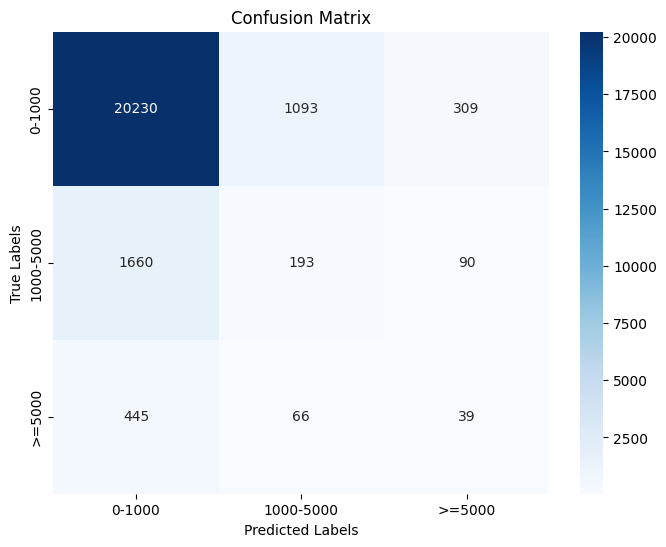

In [23]:
from sklearn.metrics import confusion_matrix

y_pred = cat_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0-1000', '1000-5000', '>=5000'],
            yticklabels=['0-1000', '1000-5000', '>=5000'])

plt.title("Confusion Matrix")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [40]:
# [i for i in range(len(X_val)) if y_val[i] == '0-1000' and y_pred[i] == '>=5000']

In [113]:
y_train.value_counts(normalize = True)

likes_class
0-1000       0.873809
1000-5000    0.099570
>=5000       0.026621
Name: proportion, dtype: float64

In [182]:
y_pred = cat_model.predict(X_val)

In [24]:
y_pred = y_pred.squeeze()

In [25]:
df_y = pd.DataFrame()
df_y['y'] = y_pred
df_y['y'].value_counts()

y
0-1000       22335
1000-5000     1352
>=5000         438
Name: count, dtype: int64

In [185]:
sum([y_pred[i] == '>=5000' and y_val[i] == '>=5000' for i in range(y_val.shape[0])])

289

In [134]:
y_val.value_counts()

likes_class
0-1000       21632
1000-5000     1943
>=5000         550
Name: count, dtype: int64

In [165]:
# (np.array(y_pred) == np.array(y_val)).mean()
accuracy_score(y_val, y_pred)

0.8327461139896373

In [55]:
y_train_cont = train_df.loc[train_indices, 'likes']
y_val_cont = train_df.loc[val_indices, 'likes']

In [186]:
mse(y_val_cont, np.ones(y_val_cont.shape)*y_train_cont.mean(), squared = False)

5499.0509467074535

In [56]:
mse(y_val_cont, [mean_likes_by_class[i] for i in y_pred], squared = False)

5838.973566875456

In [ ]:
def objective(trial):
    params = {
#         'iterations': trial.suggest_int('iterations', 500, 2000),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
#         'depth': trial.suggest_int('depth', 4, 10),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 4, 10),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#         'od_wait': trial.suggest_int('od_wait', 10, 50),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0  
    }

    cat_model = CatBoostRegressor(**params, loss_function='RMSE', eval_metric = 'RMSE', random_seed=42)
    cat_model.fit(X_train, y_train, cat_features = [0,1], eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)
    
    y_pred = cat_model.predict(X_val)
    rmse = mse(y_val, y_pred, squared=False)
    
    return rmse 

study = optuna.create_study(direction='minimize')  
study.optimize(objective, n_trials=10, timeout=600) 
print("Best parameters found: ", study.best_params)
print("Best RMSE: ", study.best_value)

best_params = study.best_params
final_model = CatBoostRegressor(**best_params, loss_function='RMSE',eval_metric = 'RMSE', random_seed=42)

final_model.fit(X_train, y_train, cat_features = [0,1], eval_set=(X_val, y_val), verbose=100)

y_pred = final_model.predict(X_val)
final_rmse = mse(y_val, y_pred, squared=False)
print(f"Final RMSE on validation set: {final_rmse}")

In [ ]:
mse(np.log1p(y_val), np.log1p(y_pred), squared=False)

In [80]:
from transformers import AutoModel, AutoTokenizer
# model_name = 'bert-base-uncased'
model = AutoModel.from_pretrained("vinai/bertweet-base")
# tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
# model = BertModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(list(train_df.loc[train_indices, 'cleaned_content']), padding=True, truncation=True, return_tensors='pt')

In [ ]:
import gc
def process_in_chunks(model, inputs, batch_size=32):
    model = model.to(device)
    model.eval()  
    all_cls_embeddings = []

    num_batches = len(inputs['input_ids']) // batch_size + 1
    
    with torch.no_grad():  
        for batch_idx in range(num_batches):
            batch_inputs = {k: v[batch_idx * batch_size : (batch_idx + 1) * batch_size].to(device)
                            for k, v in inputs.items()}
            outputs = model(**batch_inputs)
            cls_embeddings = outputs['last_hidden_state'][:, 0, :]  
            all_cls_embeddings.append(cls_embeddings.cpu()) 
            del batch_inputs, outputs, cls_embeddings
            gc.collect() 
#             torch.cuda.empty_cache()
    
    all_cls_embeddings = torch.cat(all_cls_embeddings, dim=0)
    
    return all_cls_embeddings
cls_embeddings = process_in_chunks(model, inputs, batch_size=32)
print(cls_embeddings.shape)

In [45]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

inputs = tokenizer(list(train_df.loc[val_indices, 'content']), padding=True, truncation=True, return_tensors='pt')

In [46]:
cls_embeddings_val = process_in_chunks(model, inputs, batch_size=32)

In [47]:
cls_embeddings_val.shape

torch.Size([834, 768])

In [192]:
class bert_downsample(nn.Module):
    def __init__(self, input_size, output_size):
        super(bert_downsample, self, ).__init__()
        self.fc = nn.Linear(in_features = input_size, out_features = output_size, bias = True)
    
    def forward(self, x):
        return self.fc(x)

In [100]:
train_embeddings_cls_np = cls_embeddings.detach().cpu().numpy()
embedding_columns = [f"cls_embedding_{i}" for i in range(train_embeddings_cls_np.shape[1])]
embeddings_df = pd.DataFrame(train_embeddings_cls_np, columns=embedding_columns)

df_train = pd.concat([df_train.reset_index(drop=True), embeddings_df], axis=1)

In [101]:
val_embeddings_cls_np = cls_embeddings_val.detach().cpu().numpy()
embedding_columns = [f"cls_embedding_{i}" for i in range(val_embeddings_cls_np.shape[1])]
embeddings_df = pd.DataFrame(val_embeddings_cls_np, columns=embedding_columns)

df_val = pd.concat([df_val.reset_index(drop=True), embeddings_df], axis=1)

In [63]:
class neural_net(nn.Module):
    def __init__(self, input_size, output_size):
        super(neural_net, self).__init__()
        self.linear1 = nn.Linear(in_features = input_size, out_features = 256, bias = True)
        self.bn1=nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dr1=nn.Dropout1d()
        self.linear2 = nn.Linear(in_features = 256, out_features = 128, bias = True)
        self.bn2=nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dr2=nn.Dropout1d()
        self.linear3 = nn.Linear(in_features = 128, out_features = output_size, bias = True)
    
    def forward(self, x):
        out = self.linear3(self.relu2(self.bn2(self.linear2(self.relu1(self.bn1(self.linear1(x)))))))
        return out
nn_model = neural_net(input_size = 768, output_size = 1).to(device)

In [64]:
class nn_dataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.x = X.reset_index(drop = True)
        self.y = y.reset_index(drop = True)
#         self.transform = transform
#         self.train = train
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.x.iloc[idx])
        y = torch.tensor(self.y.iloc[idx])
            
        return X, y

In [14]:
cls_embed = pd.read_csv('/kaggle/input/bertweet-embed/bertweet_full.csv')

In [38]:
cls_embed.head()

,cls_embedding_0,cls_embedding_1,cls_embedding_2,cls_embedding_3,cls_embedding_4,cls_embedding_5,cls_embedding_6,cls_embedding_7,cls_embedding_8,cls_embedding_9,...,cls_embedding_758,cls_embedding_759,cls_embedding_760,cls_embedding_761,cls_embedding_762,cls_embedding_763,cls_embedding_764,cls_embedding_765,cls_embedding_766,cls_embedding_767
0,0.023178,0.256953,0.255463,-0.083880,0.155040,-0.116542,-0.004311,-0.172761,0.241986,-0.042757,...,0.096001,0.064600,0.081336,0.042808,-0.054059,-0.045551,-0.008276,-0.076633,-0.044823,0.018629
1,-0.050998,0.342571,0.262547,0.037104,-0.010318,-0.184741,0.089130,-0.082990,0.004877,-0.016541,...,0.227574,0.080511,0.164396,-0.027190,0.179126,-0.132649,0.128336,0.005677,-0.157179,0.019753
2,-0.020711,0.330396,0.212147,0.012729,0.149838,-0.148308,0.078521,-0.032911,0.080688,-0.103758,...,0.089377,0.111796,0.059127,0.094234,-0.050855,-0.073519,0.086718,-0.052929,-0.147353,-0.031610
3,-0.228080,0.218385,0.216307,0.090867,0.020311,-0.110163,0.247068,-0.103976,0.056986,-0.020619,...,0.041639,0.037614,0.173647,-0.006084,0.134102,-0.042047,0.114400,0.037825,-0.045736,-0.242749
4,-0.030641,0.245888,0.326784,-0.088516,-0.073143,-0.171603,0.170291,-0.196158,0.027403,-0.079542,...,0.173601,0.003438,0.187752,0.067493,0.033600,-0.045521,-0.072449,-0.228149,-0.048607,-0.094895


In [16]:
# del cls_embed['idx']
del cls_embed['Unnamed: 0']

In [24]:
X_train = cls_embed.iloc[train_indices].reset_index(drop = True)
y_train = train_df.loc[train_indices, 'likes_class'].reset_index(drop = True)
X_val = cls_embed.iloc[val_indices].reset_index(drop = True)
y_val = train_df.loc[val_indices, 'likes_class'].reset_index(drop = True)

In [38]:
sampler = RandomUnderSampler(sampling_strategy = 'auto', random_state=42)
X_train, y_train = sampler.fit_resample(X_train, y_train)

In [23]:
nn_train_data = nn_dataset(X_train, y_train)
nn_val_data = nn_dataset(X_val, y_val)
nn_train_dataloader = DataLoader(nn_train_data, batch_size = 32, shuffle = False, num_workers = os.cpu_count())
nn_val_dataloader = DataLoader(nn_val_data, batch_size = 32, shuffle = False, num_workers = os.cpu_count())

In [65]:
batch_size = 32

train_dataset1 = nn_dataset(X_train1, y_train1)
train_dataset2 = nn_dataset(X_train2, y_train2)
train_dataset3 = nn_dataset(X_train3, y_train3)

val_dataset1 = nn_dataset(X_val1, y_val1)
val_dataset2 = nn_dataset(X_val2, y_val2)
val_dataset3 = nn_dataset(X_val3, y_val3)

train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)

val_loader1 = DataLoader(val_dataset1, batch_size=batch_size, shuffle=False)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False)
val_loader3 = DataLoader(val_dataset3, batch_size=batch_size, shuffle=False)

In [66]:
model1 = neural_net(input_size = 768, output_size = 1).to(device)
model2 = neural_net(input_size = 768, output_size = 1).to(device)
model3 = neural_net(input_size = 768, output_size = 1).to(device)

In [56]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# loss_fn = RMSELoss()
# optimizer_nn = torch.optim.Adam(params = nn_model.parameters())
# LR_scheduler = troch.optim.lr_scheduler.StepLR(optimizer, 4, 0.1)

In [69]:
import gc
torch.cuda.empty_cache()
gc.collect()
n_epochs = 100
for nn_model, nn_train_dataloader, nn_val_dataloader  in [(model3, train_loader3, val_loader3), (model2, train_loader2, val_loader2), (model1, train_loader1, val_loader1)]:
    optimizer_nn = torch.optim.SGD(params = nn_model.parameters(), lr = 1e-3)
    loss_fn = RMSELoss()
    for epoch in range(n_epochs):
        nn_model.train()
        net_loss = 0.0
        for X, y in tqdm(nn_train_dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(torch.float32).to(device)
            optimizer_nn.zero_grad()
            y_pred = nn_model(X)
            loss = loss_fn(y_pred, y)
            net_loss += (loss.item()) / len(nn_train_dataloader)
            loss.backward()
            optimizer_nn.step()
            del X,y
        print(f"epoch {epoch+1} | Train Loss: {net_loss}")

        nn_model.eval()
        net_loss_val = 0.0
        with torch.inference_mode():
            for X, y in tqdm(nn_val_dataloader):
                X = X.to(torch.float32).to(device)
                y = y.to(torch.float32).to(device)
                y_val_pred = nn_model(X)
                val_loss = loss_fn(y_val_pred, y)
                net_loss_val += (val_loss.item()) / len(nn_val_dataloader)
                del X,y
            print(f"epoch {epoch+1} | Val Loss: {net_loss_val}")

  0%|          | 0/230 [00:00<?, ?it/s]

epoch 1 | Train Loss: 26183.985372792115


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 1 | Val Loss: 28120.388780381945


  0%|          | 0/230 [00:00<?, ?it/s]

epoch 2 | Train Loss: 25848.320554517646


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 2 | Val Loss: 28061.009223090274


  0%|          | 0/230 [00:00<?, ?it/s]

epoch 3 | Train Loss: 25609.49559273097


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 3 | Val Loss: 27983.86241319445


  0%|          | 0/230 [00:00<?, ?it/s]

epoch 4 | Train Loss: 25551.5169752038


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 4 | Val Loss: 27885.0263671875


  0%|          | 0/230 [00:00<?, ?it/s]

epoch 5 | Train Loss: 25854.217000679346


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 5 | Val Loss: 27749.48611111111


  0%|          | 0/230 [00:00<?, ?it/s]

epoch 6 | Train Loss: 25377.094382642656


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 6 | Val Loss: 27580.463487413195


  0%|          | 0/230 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [153]:
(mse(y_val1, np.ones(y_val1.shape)*y_train1.mean(), squared = False) + 2258 + 27873)/3.0

10110.013282121512

In [151]:
y_val1.mean()

999

In [154]:
y_p = []
y_g = []
with torch.inference_mode():
    for X, y in tqdm(val_loader3):
        X = X.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        y_val_pred = model3(X)
        y_g.append(y)
        y_p.append(y_val_pred)
        val_loss = loss_fn(y_val_pred, y)
        net_loss_val += (val_loss.item()) / len(nn_val_dataloader)
        del X,y

  0%|          | 0/18 [00:00<?, ?it/s]

In [155]:
y_p = torch.cat(y_p, dim = 0)
y_g = torch.cat(y_g, dim = 0)

In [171]:
y_g.min()

tensor(5020., device='cuda:0')

In [161]:
train_df.iloc[275726]['likes_class']

'>=5000'

In [141]:
mse(y_val, np.ones(y_val.shape)*y_train.mean(), squared = False)

2650.4214398588574

In [119]:
train_df['likes_class'].value_counts(normalize = True)

likes_class
0-1000       0.875647
1000-5000    0.098040
>=5000       0.026313
Name: proportion, dtype: float64